In [1]:
#!pip install langgraph

In [2]:
# Standard library imports
import os
from typing import TypedDict, List

# Third-party imports
from dotenv import load_dotenv

# LangGraph imports for workflow graph creation
from langgraph.graph import StateGraph, END

# LangChain imports for LLM integration
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from langchain_openai import ChatOpenAI

# Jupyter display utilities
from IPython.display import display, Image

In [3]:
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY");

<h2>Building the Text Processing Pipeline</h2>

<h5>Define State and Initialize LLM</h5>

In [5]:
# Define a TypedDict class to represent the state of processed text
# TypedDict is a special dictionary type from typing module that allows specifying
# the types of allowed keys and their corresponding value types
class State(TypedDict):
    text: str                # The original text input
    classification: str      # The classification category of the text
    entities: List[str]      # List of entities extracted from the text
    summary: str             # A summary of the text content

# Initialize the language model using OpenAI's GPT-4o-mini
# Setting temperature to 0.0 for deterministic/consistent outputs
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

<h5>Define Node Functions</h5>
<h6>These functions define the operations performed at each node of our graph: classification, entity extraction, and summarization.</h6>

In [7]:
def classification_node(state: State):
    ''' Classify the text into one of the categories: News, Blog, Research, or Other '''
    # Create a prompt template with a placeholder for the text to be classified
    prompt = PromptTemplate(
        input_variables=["text"],  # Define the variable that will be replaced in the template
        template="Classify the following text into one of the categories: News, Blog, Research, or Other.\n\nText:{text}\n\nCategory:"
    )
    
    # Format the prompt with the text from the state and create a human message
    message = HumanMessage(content=prompt.format(text=state["text"]))
    #print(f"message: {message}")
    
    # Send the message to the language model and get the classification result
    classification = llm.invoke([message]).content.strip()
    
    # Return the classification result as a dictionary
    return {"classification": classification}

In [8]:
def entity_extraction_node(state: State):
    ''' Extract all the entities (Person, Organization, Location) from the text '''
    # Create a prompt template with a placeholder for the text input
    # This template asks the LLM to extract entities and return them as a comma-separated list
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Extract all the entities (Person, Organization, Location) from the following text. Provide the result as a comma-separated list.\n\nText:{text}\n\nEntities:"
    )

    # Create a human message using the formatted prompt with the text from the state
    message = HumanMessage(content=prompt.format(text=state["text"]))
    
    # Send the message to the language model and get the response
    # Split the response by commas to create a list of entities
    entities = llm.invoke([message]).content.strip().split(", ")
    
    # Return the extracted entities as a dictionary
    return {"entities": entities}

In [9]:
def summarization_node(state: State):
    ''' Summarize the text in one short sentence '''
    # Create a prompt template with a placeholder for the text to be summarized
    prompt = PromptTemplate(
        input_variables=["text"],
        template="Summarize the following text in one short sentence.\n\nText:{text}\n\nSummary:"
    )
    # Format the prompt with the text from the state and create a human message
    message = HumanMessage(content=prompt.format(text=state["text"]))
    # Invoke the language model with the message and extract the generated summary
    summary = llm.invoke([message]).content.strip()
    # Return the summary as a dictionary to be used in the workflow
    return {"summary": summary}

<h5>Create Tools and Build Workflow</h5>

In [11]:
# Initialize a StateGraph with State as the base state type
workflow = StateGraph(State)

# Add processing nodes to the workflow
workflow.add_node("classification_node", classification_node)  # Node for text classification
workflow.add_node("entity_extraction", entity_extraction_node)  # Node for extracting entities
workflow.add_node("summarization", summarization_node)  # Node for text summarization

# Set the starting point of the workflow
workflow.set_entry_point("classification_node")

# Define the flow between nodes
workflow.add_edge("classification_node", "entity_extraction")  # After classification, perform entity extraction
workflow.add_edge("entity_extraction", "summarization")  # After entity extraction, perform summarization
workflow.add_edge("summarization", END)  # End the workflow after summarization

# Compile the workflow into an executable application
app = workflow.compile()

<h5>Visualizing the Workflow</h5>

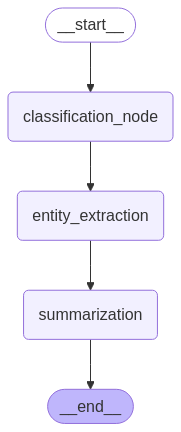

In [13]:
display(
    Image(
        app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API,)
    )
)

<h5>Test the pipeline</h5>

In [15]:
import time

sample_text = """
OpenAI has announced the GPT-4 model, which is a large multimodal model that exhibits human-level performance on various professional benchmarks. It is developed to improve the alignment and safety of AI systems.
additionally, the model is designed to be more efficient and scalable than its predecessor, GPT-3. The GPT-4 model is expected to be released in the coming months and will be available to the public for research and development purposes.
"""

# Add retry logic with exponential backoff
max_retries = 5
retry_delay = 1  # Start with 1 second delay

for attempt in range(max_retries):
    try:
        state_input = {"text": sample_text}
        result = app.invoke(state_input)
        
        print("Classification:", result["classification"])
        print("\nEntities:", result["entities"])
        print("\nSummary:", result["summary"])
        break  # Success, exit the retry loop
        
    except Exception as e:
        if "insufficient_quota" in str(e) or "rate_limit" in str(e):
            if attempt < max_retries - 1:  # Don't sleep on the last attempt
                print(f"Rate limit hit. Retrying in {retry_delay} seconds...")
                time.sleep(retry_delay)
                retry_delay *= 2  # Exponential backoff
            else:
                print("Max retries reached. Please check your API quota.")
        else:
            # For other errors, just raise them
            raise

Rate limit hit. Retrying in 1 seconds...
Rate limit hit. Retrying in 2 seconds...
Rate limit hit. Retrying in 4 seconds...
Rate limit hit. Retrying in 8 seconds...
Max retries reached. Please check your API quota.
